In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_loader import DataLoader

%load_ext autoreload
%autoreload 2

<img src=https://i.stack.imgur.com/gyuw4.png>

In [2]:
def get_color_pixels(image, color):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    if color == "black":
        return cv2.inRange(image_hsv, (0, 0, 0), (180, 255, 30))

    elif color == "green":
        return cv2.inRange(image_hsv, (40, 50, 30), (75, 255, 255))
        
    elif color == "red":
        mask1 = cv2.inRange(image_hsv, (0, 70, 50), (10, 255, 255))
        mask2 = cv2.inRange(image_hsv, (170, 70, 50), (180, 255, 255))
        return cv2.bitwise_or(mask1, mask2)
    
    else:
        raise ValueError(f"Color parameter must be one of 'black', 'green', 'red'. Got: {color}")

In [3]:
data_loader = DataLoader()

In [4]:
image, _ = data_loader[1,1]

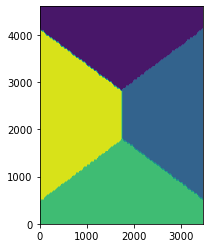

In [5]:
from scipy.spatial.distance import cdist

def associate_point_to_player(image_shape, point):
    image_rows, image_columns = image_shape
    point_row , point_column  = point
    
    player_points = [(image_rows, image_columns / 2), (image_rows / 2, image_columns), (0, image_columns / 2), (image_rows / 2, 0)]
    
    distances = cdist(player_points, [point])
    
    player = np.argmin(distances) + 1
    
    return player


n_rows, n_cols, _ = image.shape
rows_list = np.linspace(0, n_rows-1, 100)
cols_list = np.linspace(0, n_cols-1, 100)
rows_mesh, cols_mesh = np.meshgrid(rows_list, cols_list)

res = [associate_point_to_player((n_rows, n_cols), (p1, p2)) for p1, p2 in zip(rows_mesh.ravel(), cols_mesh.ravel())]
res = np.reshape(res, rows_mesh.shape)

plt.contourf(cols_mesh, rows_mesh, res)
plt.gca().set_aspect('equal')

In [6]:
global widht_height_list
width_height_list = []


class Extractor():
    
    def __init__(self, canny_thresholds = (25, 100), hough_circles_parameters = (50, 30), sigma_gaussian_blur = 5,
                 smaller_card_side_range = (400, 700), larger_card_size_range = (600, 900)):
        self.canny_thresholds = canny_thresholds
        self.hough_circles_parameters = hough_circles_parameters
        self.sigma_gaussian_blur = sigma_gaussian_blur
        
        self.smaller_card_side_range = (min(smaller_card_side_range), max(smaller_card_side_range))
        self.larger_card_size_range  = (min(larger_card_size_range ), max(larger_card_size_range ))
        
        
        
        
    def _extract(self, image):
        column, row, radius = self._extract_dealer(image)
        
        gradient = cv2.Canny(image, *self.canny_thresholds) 

        gradient_no_circle = cv2.circle(gradient, (column, row), int(radius * 1.1), (0, 0, 0), cv2.FILLED)
        gradient_no_circle_blurred = cv2.GaussianBlur(gradient_no_circle, None, sigmaX = self.sigma_gaussian_blur)
        
        # Here as we don't use hierarcy returned parameter we don't need RETR_TREE and we can use RETR_LIST
        contours, _ = cv2.findContours(gradient_no_circle_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        bounding_boxes = []
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            if self._bbox_can_be_card(bbox):
                bounding_boxes.append(bbox)
        
        indices = cv2.dnn.NMSBoxes(bounding_boxes, [w*h for _, _, w, h in bounding_boxes], 0, 0.3)
        bounding_boxes = [bbox for idx, bbox in enumerate(bounding_boxes) if idx in indices]
        
        return associate_point_to_player((image.shape[0], image.shape[1]), (row, column)), bounding_boxes
        
        
        
    def _extract_dealer(self, image):
        green_mask  = get_color_pixels(image, "green")

        # Extract circle.
        circles = cv2.HoughCircles(green_mask, cv2.HOUGH_GRADIENT, dp = 1,
                                   minDist = np.inf, 
                                   param1  = self.hough_circles_parameters[0], 
                                   param2  = self.hough_circles_parameters[1])

        circles = np.uint16(np.around(circles))

        # Take the only circle detected, as we put a high minimum distance.
        column, row, radius = circles[0][0]
        
        # Show detection.
        #plt.imshow(image[row-radius:row+radius,column-radius:column+radius][:,:,::-1])
        #plt.show()
        
        return column, row, radius
        
        # Determine which player is dealer.
        image_rows, image_cols, _ = image.shape
        dealer = associate_point_to_player((image_rows, image_cols), (row, column))
        
        return dealer
    
    
    def _bbox_can_be_card(self, bbox):
        _, _, width, height = bbox
        
        width_height_list.append(width)
        width_height_list.append(height)

        width_in_smaller_range = self.smaller_card_side_range[0] <= width <= self.smaller_card_side_range[1]
        width_in_larger_range  = self.larger_card_size_range [0] <= width <= self.larger_card_size_range [1]

        height_in_smaller_range = self.smaller_card_side_range[0] <= height <= self.smaller_card_side_range[1]
        height_in_larger_range  = self.larger_card_size_range [0] <= height <= self.larger_card_size_range [1]
        
        return (width_in_smaller_range and height_in_larger_range) or (width_in_larger_range and height_in_smaller_range)
    

    def __call__(self, image):
        return self._extract(image)

In [7]:
data_loader = DataLoader()
extractor = Extractor()

Game: 1, Round: 1


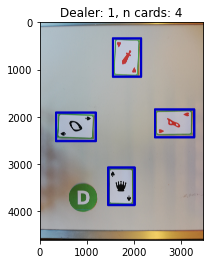

Game: 1, Round: 2


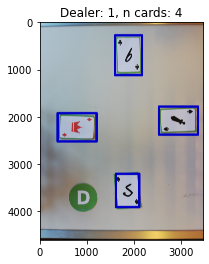

Game: 1, Round: 3


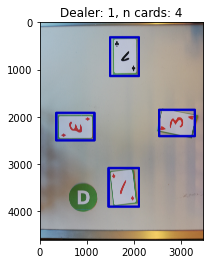

Game: 1, Round: 4


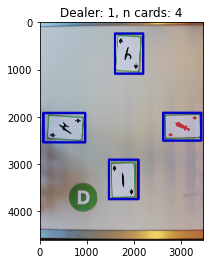

Game: 1, Round: 5


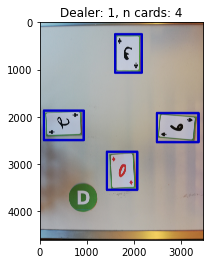

Game: 1, Round: 6


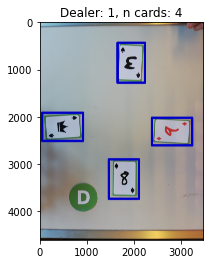

Game: 1, Round: 7


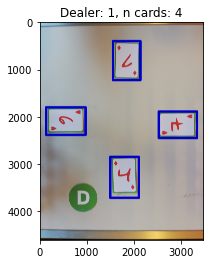

Game: 1, Round: 8


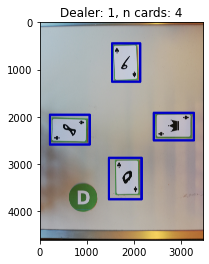

Game: 1, Round: 9


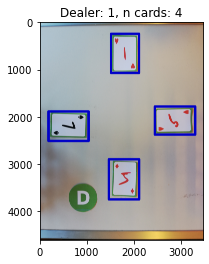

Game: 1, Round: 10


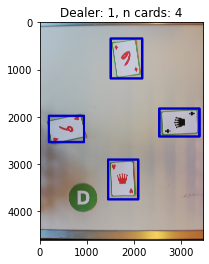

Game: 1, Round: 11


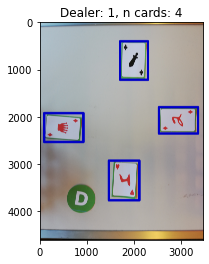

Game: 1, Round: 12


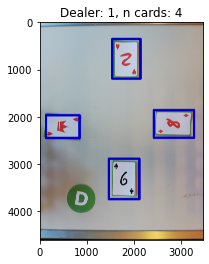

Game: 1, Round: 13


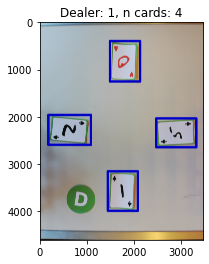

Game: 2, Round: 1


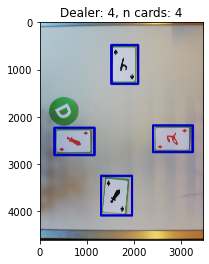

Game: 2, Round: 2


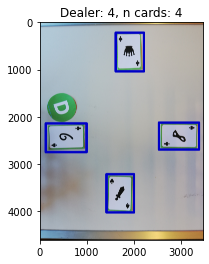

Game: 2, Round: 3


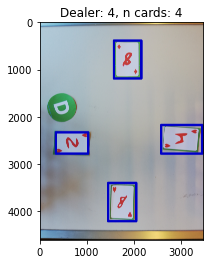

Game: 2, Round: 4


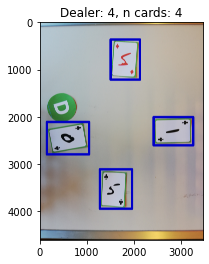

Game: 2, Round: 5


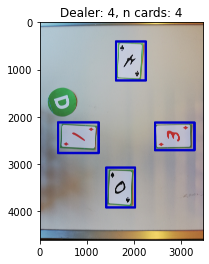

Game: 2, Round: 6


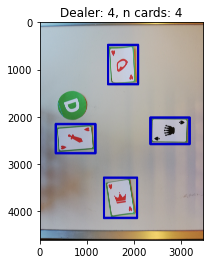

Game: 2, Round: 7


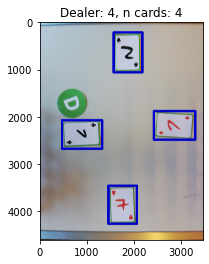

Game: 2, Round: 8


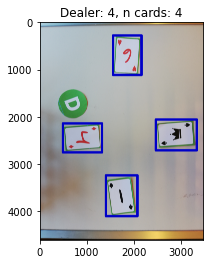

Game: 2, Round: 9


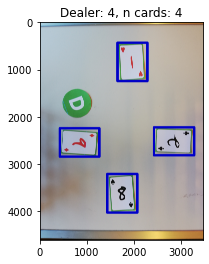

Game: 2, Round: 10


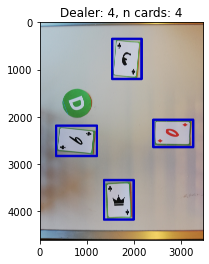

Game: 2, Round: 11


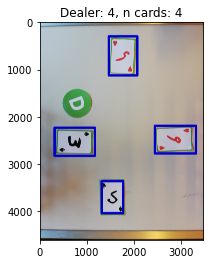

Game: 2, Round: 12


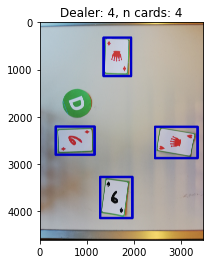

Game: 2, Round: 13


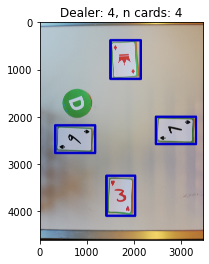

Game: 3, Round: 1


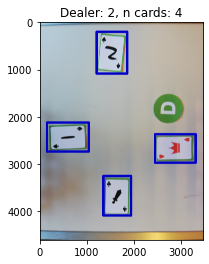

Game: 3, Round: 2


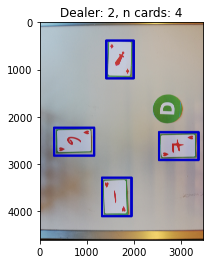

Game: 3, Round: 3


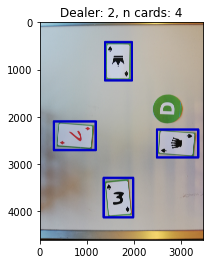

Game: 3, Round: 4


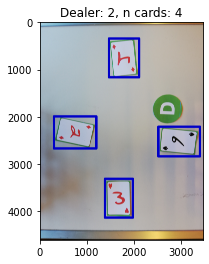

Game: 3, Round: 5


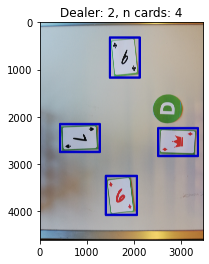

Game: 3, Round: 6


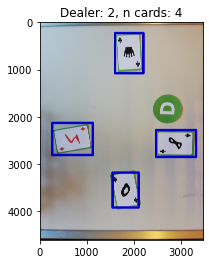

Game: 3, Round: 7


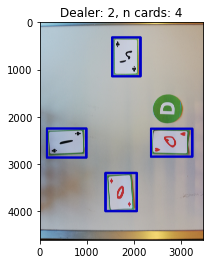

Game: 3, Round: 8


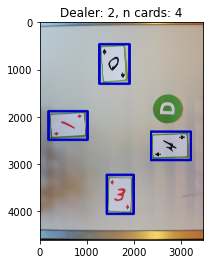

Game: 3, Round: 9


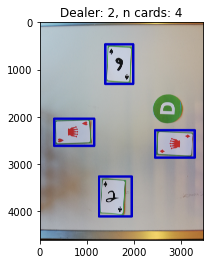

Game: 3, Round: 10


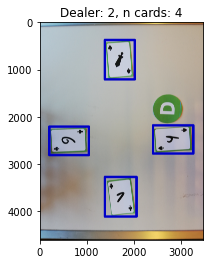

Game: 3, Round: 11


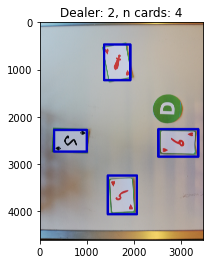

Game: 3, Round: 12


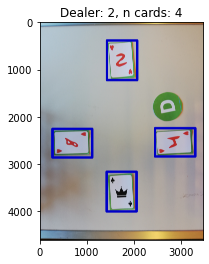

Game: 3, Round: 13


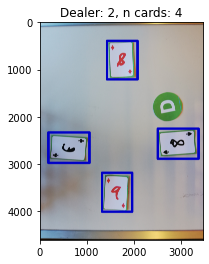

Game: 4, Round: 1


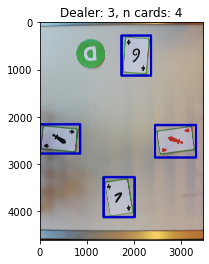

Game: 4, Round: 2


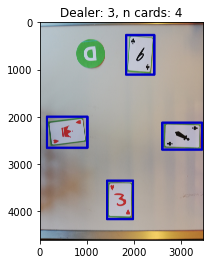

Game: 4, Round: 3


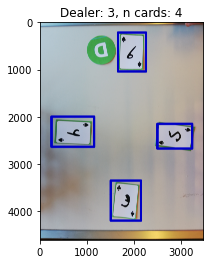

Game: 4, Round: 4


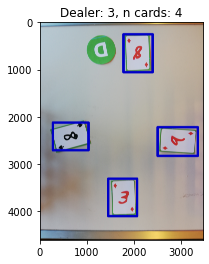

Game: 4, Round: 5


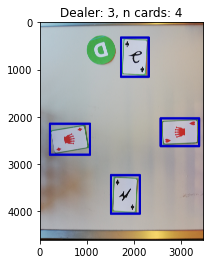

Game: 4, Round: 6


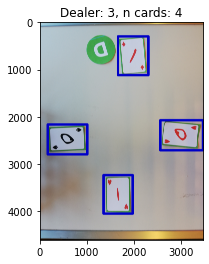

Game: 4, Round: 7


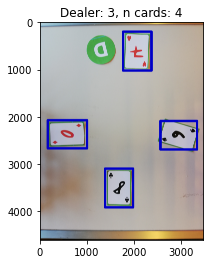

Game: 4, Round: 8


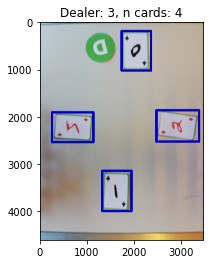

Game: 4, Round: 9


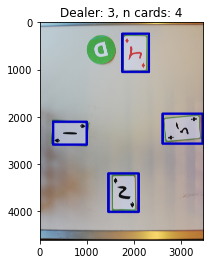

Game: 4, Round: 10


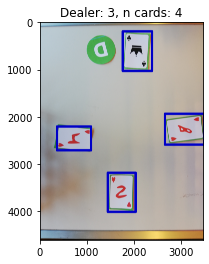

Game: 4, Round: 11


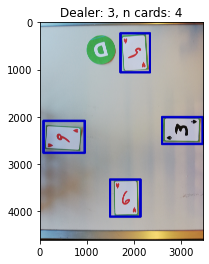

Game: 4, Round: 12


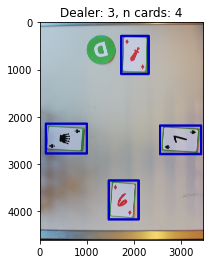

Game: 4, Round: 13


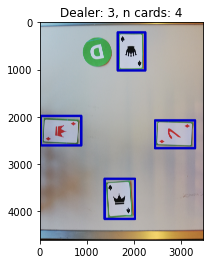

Game: 5, Round: 1


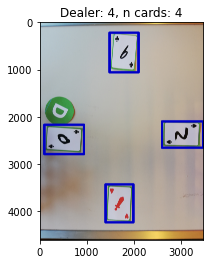

Game: 5, Round: 2


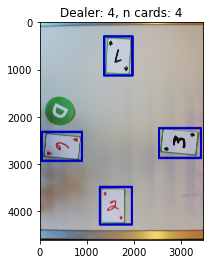

Game: 5, Round: 3


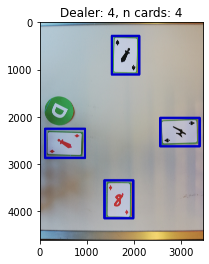

Game: 5, Round: 4


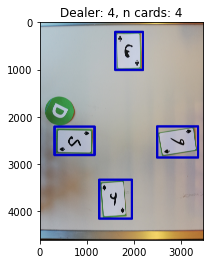

Game: 5, Round: 5


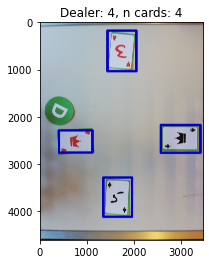

Game: 5, Round: 6


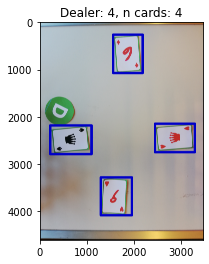

Game: 5, Round: 7


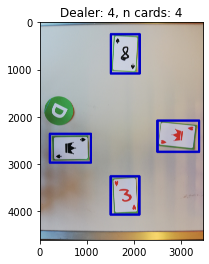

Game: 5, Round: 8


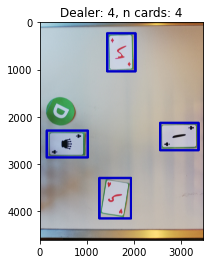

Game: 5, Round: 9


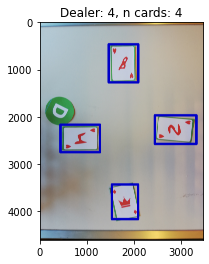

Game: 5, Round: 10


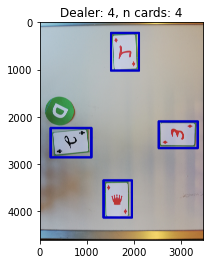

Game: 5, Round: 11


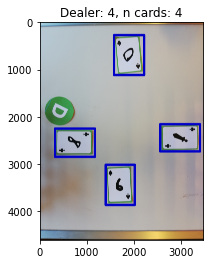

Game: 5, Round: 12


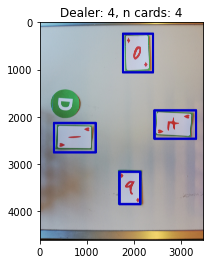

Game: 5, Round: 13


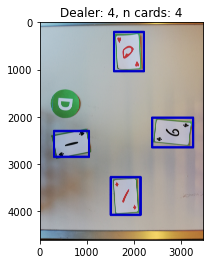

Game: 6, Round: 1


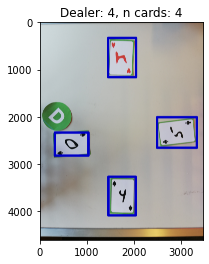

Game: 6, Round: 2


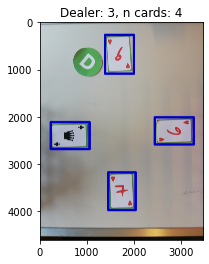

Game: 6, Round: 3


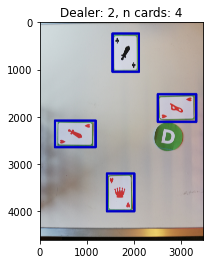

Game: 6, Round: 4


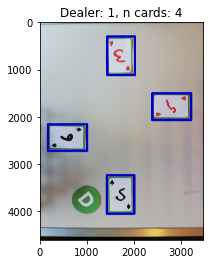

Game: 6, Round: 5


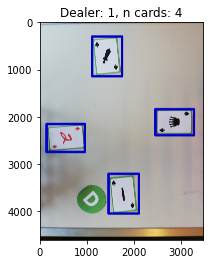

Game: 6, Round: 6


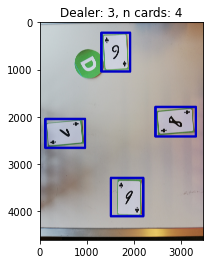

Game: 6, Round: 7


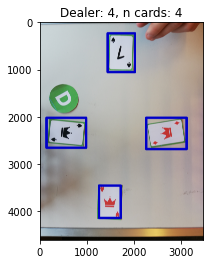

Game: 6, Round: 8


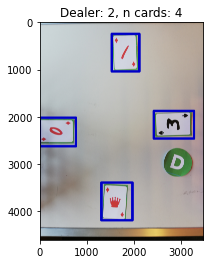

Game: 6, Round: 9


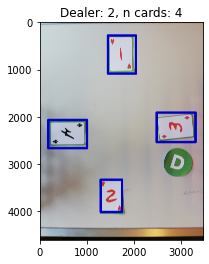

Game: 6, Round: 10


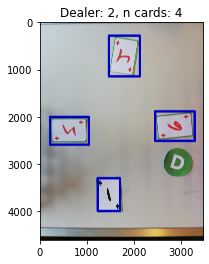

Game: 6, Round: 11


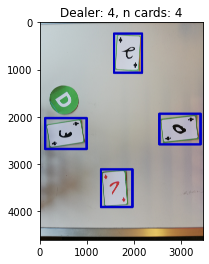

Game: 6, Round: 12


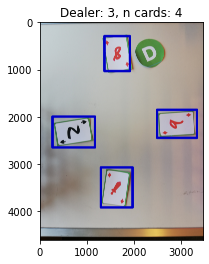

Game: 6, Round: 13


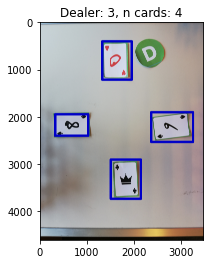

Game: 7, Round: 1


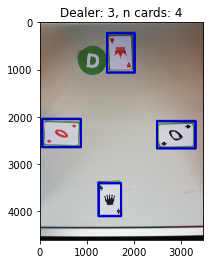

Game: 7, Round: 2


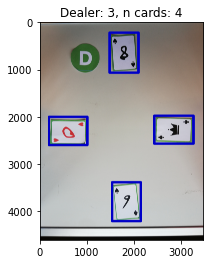

Game: 7, Round: 3


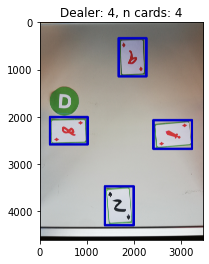

Game: 7, Round: 4


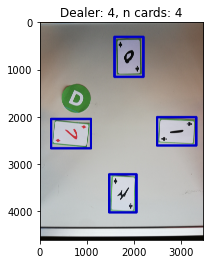

Game: 7, Round: 5


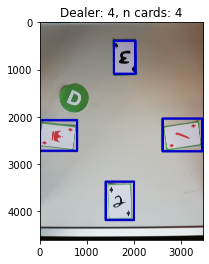

Game: 7, Round: 6


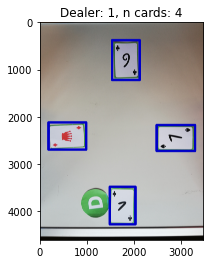

Game: 7, Round: 7


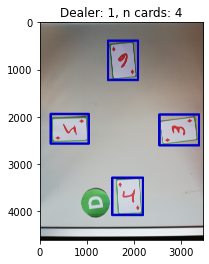

Game: 7, Round: 8


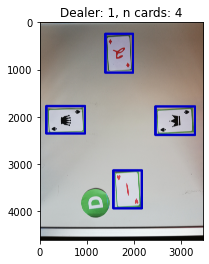

Game: 7, Round: 9


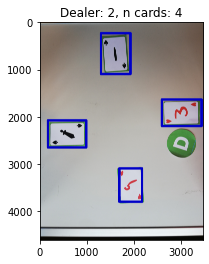

Game: 7, Round: 10


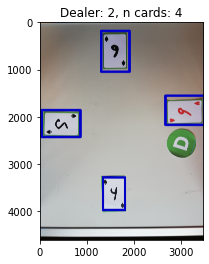

Game: 7, Round: 11


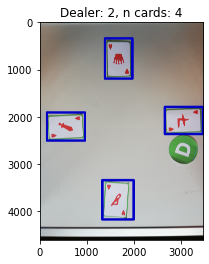

Game: 7, Round: 12


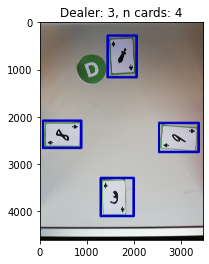

Game: 7, Round: 13


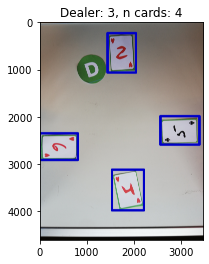

In [8]:
for game in range(1, 7+1):
    for round_ in range(1, 13+1):
        print("Game: {}, Round: {}".format(game, round_))
        image, _ = data_loader[game, round_]
        dealer, cards = extractor(image)
        
        for c in cards:
            x,y,w,h = c
            cv2.rectangle(image, (x,y), (x+w,y+h), (200,0,0), 50)
        
        plt.imshow(image[:,:,::-1])
        plt.title("Dealer: " + str(dealer) + ", n cards: " + str(len(cards)))
        plt.show()

(array([ 9., 13., 15.,  0.,  9., 11., 12.,  0., 11., 11.,  4.,  0., 10.,
         5.,  8.,  0.,  3.,  3.,  9.,  0.,  7.,  6.,  7.,  0.,  7., 11.,
        13.,  0.,  6.,  6.,  5.,  0.,  7.,  8.,  5.,  0.,  2.,  3.,  7.,
         0.,  6.,  7.,  7.,  0.,  7.,  5.,  9.,  0.,  8.,  5.,  7.,  0.,
         8.,  9.,  5.,  0., 10.,  6.,  9.,  0., 10., 10., 13.,  0.,  8.,
         5., 13.,  0.,  9., 11., 16.,  0.,  7., 13.,  6.,  0.,  8.,  7.,
        10.,  0.,  6., 15., 12.,  0., 18., 12.,  9.,  0., 12.,  9.,  8.,
         0.,  6.,  8.,  7.,  0.,  6.,  1.,  6.,  0.,  6.,  1.,  2.,  0.,
         5.,  9.,  6.,  0.,  4.,  1.,  5.,  0., 10.,  5.,  5.,  0., 11.,
         8., 10.,  0.,  8.,  1.,  6.,  0.,  8.,  5.,  4.,  0.,  7.,  3.,
         7.,  0., 10.,  7., 11.,  0.,  9.,  9.,  7.,  0.,  8.,  9.,  8.,
         0.,  4., 12., 11.,  0.,  7.,  7.,  7.,  0.,  9.,  5.,  6.,  0.,
        10.,  7., 14.,  0., 10.,  7.,  7.,  0., 11.,  7.,  3.,  0.,  2.,
         6.,  4.,  0.,  4.,  1.,  5.,  0.,  3.,  3.

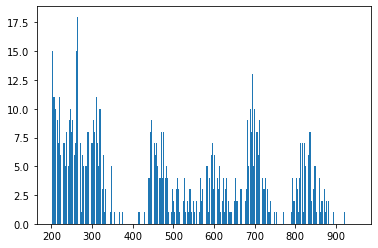

In [9]:
plt.hist([elem for elem in width_height_list if elem > 200 and elem < 1000], bins=1000)